A notebook for generating the final results for a fully cross-validated transfer analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import os
import os.path
import pathlib
import pickle
import re

import matplotlib.pyplot as plt
import numpy as np

from ahrens_wbo.visualization import plot_segmented_signal

from janelia_core.stats.regression import r_squared
from janelia_core.utils.file_system import get_immediate_subfolders

In [3]:
%matplotlib notebook

## Parameters go here

In [4]:
# A list of of base_folders with the results of different analyses.  A single analysis consists of 
# runing the full cross-validated results with multiple amounts of training data for models fit
# both individually and combined, with a *single* set of parameters.  In this convention, we could 
# run different analyses using different numbers of hypercubes in the prior, for example, and then compare results. 

base_folders = [r'/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/real_data/gnlr/same_cond_transfer_analysis/v19']

# The names of files holding post-processed results for each type of analysis
results_files = ['pp_test_results.pkl']

# Subjects we want to evaluate performance on
eval_subjs = [8, 10, 11]

subj_clrs = np.asarray([[1.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0], 
                        [0.0, 0.0, 1.0]])

# Training quantities we want to evaluate performance on
tq_strings = ['fold_str_base_14_tgt_1', 
              'fold_str_base_14_tgt_2',
              'fold_str_base_14_tgt_4',
              'fold_str_base_14_tgt_8',
              'fold_str_base_14_tgt_14']
tq_fracs = np.asarray([1.0/14, 
                       2.0/14, 
                       4.0/14,
                       8.0/14,
                       14.0/14.0])

# Folder to save results in 
save_folder = r'/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/real_data/gnlr/same_cond_transfer_analysis/v19'


# Size of figure to create
figsize = [3, 2]

## Define helper functions here

In [5]:
def rmse(truth, est):
    return np.sqrt(np.mean((truth - est)**2, axis=0))

In [6]:
def corr(truth, est):
    n_vars = truth.shape[1]
    corr_coefs = np.zeros(n_vars)
    for v_i in range(n_vars):
        corr_coefs[v_i] = np.corrcoef(truth[:, v_i], est[:, v_i], rowvar=False)[0,1]
    return corr_coefs

In [7]:
def get_analysis_results(base_folder, results_file, fit_type: str = 'ip', data_type: str = 'test'):
    training_quantity_folders = get_immediate_subfolders(base_folder)
    tq_rs = dict()
    for tq_folder in training_quantity_folders:
        tq_folder_path = pathlib.Path(base_folder) / tq_folder
        fold_folders = get_immediate_subfolders(tq_folder_path)
        n_folds = len(fold_folders)
        fold_rs = dict()
        for fold_folder in fold_folders:
            cur_fold = int(re.match('.*_(\d*)', fold_folder)[1])
            fold_folder_path = pathlib.Path(tq_folder_path) / fold_folder
            subj_folders = get_immediate_subfolders(fold_folder_path)
            n_subjs = len(subj_folders)
            subj_rs = dict()
            for subj_folder in subj_folders:
                subj_folder_path = pathlib.Path(fold_folder_path) / subj_folder
                type_folders = get_immediate_subfolders(subj_folder_path)
                eval_subj = int(re.match('.*_(\d*)', subj_folder)[1])
                type_rs = dict()
                for type_folder in type_folders:
                    cur_type = type_folder
                    type_folder_path = pathlib.Path(subj_folder_path) / type_folder
                    results_file_path = type_folder_path / results_file
                    with open(results_file_path, 'rb') as f: 
                        rs = pickle.load(f)
                        r_sq = r_squared(rs[fit_type]['preds'][eval_subj][data_type]['y'], 
                                         rs[fit_type]['preds'][eval_subj][data_type]['y_hat'])
                        
                        rmse_vls = rmse(rs[fit_type]['preds'][eval_subj][data_type]['y'], 
                                        rs[fit_type]['preds'][eval_subj][data_type]['y_hat'])
                        
                        corr_vls = corr(rs[fit_type]['preds'][eval_subj][data_type]['y'], 
                                        rs[fit_type]['preds'][eval_subj][data_type]['y_hat'])
                        
                        raw_vls = {'truth': rs[fit_type]['preds'][eval_subj][data_type]['y'], 
                                   'est': rs[fit_type]['preds'][eval_subj][data_type]['y_hat'], 
                                   't': rs[fit_type]['preds'][eval_subj][data_type]['t']}
                        
                        type_rs[cur_type] = {'r_sq': r_sq, 'rmse': rmse_vls, 'corr': corr_vls, 'raw': raw_vls}
                subj_rs[eval_subj] = type_rs
            fold_rs[cur_fold] = subj_rs
        tq_rs[tq_folder] = fold_rs
    return tq_rs

In [8]:
def get_subj_rs(rs, subj, fit_type: str = 'ind', metric: str = 'rmse'):
    """ Gets average performance for a single subject, for each for fold, for a single fit type 
        for a single training quantity. """
    n_folds = len(rs)
    folds = np.sort(np.asarray(list(rs.keys())))
    
    fold_rs = np.zeros(n_folds)
    for f_i, f_n in enumerate(folds):
        fold_rs[f_i] = np.mean(rs[f_n][subj][fit_type][metric])
    return fold_rs

In [9]:
def get_avg_fit_type_rs_for_fixed_training_quantity(rs, subjs, fit_type: str = 'ind', metric: str = 'rmse'):
    """ Gets average and standard error of performance across folds for multiple subjects for a single fit type
        and for a single training quantity."""
    n_subjs = len(subjs)
    mn_rs = np.zeros(n_subjs)
    std_er_rs = np.zeros(n_subjs)
    for s_i, subj in enumerate(subjs):
        fold_rs = get_subj_rs(rs, subj=subj, fit_type=fit_type, metric=metric)
        mn_rs[s_i] = np.mean(fold_rs)
        std_er_rs[s_i] = np.std(fold_rs)/np.sqrt(len(fold_rs))
    return [mn_rs, std_er_rs]
        
        

In [10]:
def get_fit_type_rs(rs, train_quantity_keys, subjs, fit_type: str = 'ind', metric: str = 'rmse'):
    n_train_quantity_keys = len(train_quantity_keys)
    n_subjs = len(subjs)
    mn_rs = np.zeros([n_train_quantity_keys, n_subjs])
    std_er_rs = np.zeros([n_train_quantity_keys, n_subjs])
    for tq_i, tq_key in enumerate(train_quantity_keys):
        mn_rs[tq_i, :],  std_er_rs[tq_i, :] = get_avg_fit_type_rs_for_fixed_training_quantity(rs[tq_key], 
                                                                                              subjs, fit_type, 
                                                                                              metric)
    return mn_rs, std_er_rs

## Get results

In [11]:
c_rs = get_analysis_results(base_folders[0], results_files[0])

In [12]:
comb_rmse_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='comb', metric='rmse')
ind_rmse_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='ind', metric='rmse')

comb_corr_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='comb', metric='corr')
ind_corr_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='ind', metric='corr')

comb_r_sq_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='comb', metric='r_sq')
ind_r_sq_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='ind', metric='r_sq')

## Plot results

In [13]:
plot_results = [(comb_rmse_rs, ind_rmse_rs), 
                (comb_corr_rs, ind_corr_rs), 
                (comb_r_sq_rs, ind_r_sq_rs)]

plot_strs = ['RMSE', 'Corr', 'R Sq.']

<IPython.core.display.Javascript object>


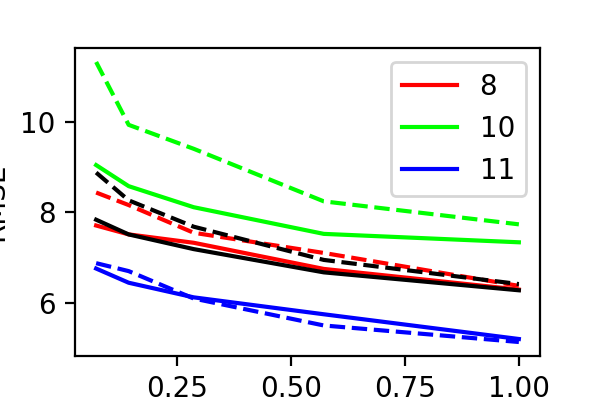

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>


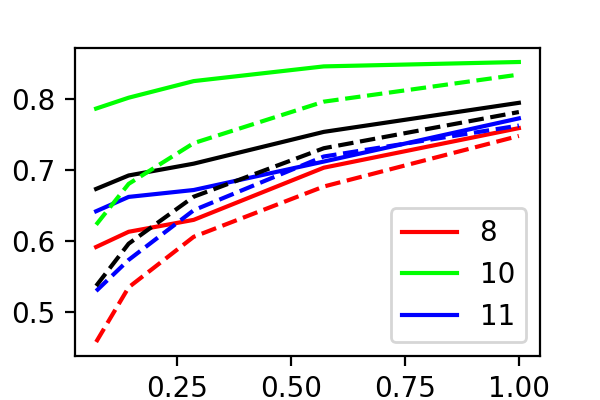

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>


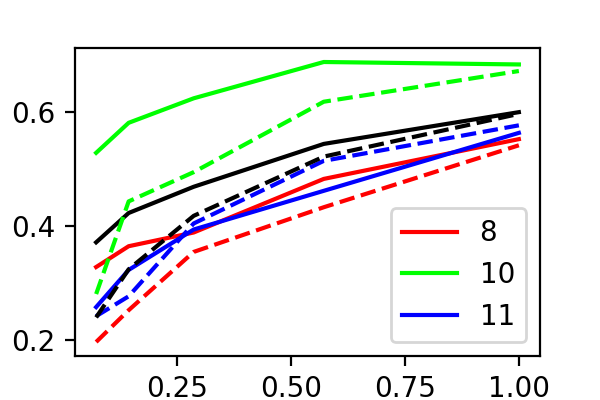

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [16]:
for plot_rs, plot_str in zip(plot_results, plot_strs):
    
    fig, ax = plt.subplots(figsize=figsize)

    for s_i, subj in enumerate(eval_subjs):
        plt.plot(tq_fracs, plot_rs[0][0][:, s_i], '-', color=subj_clrs[s_i])
    plt.legend(eval_subjs)
    
    comb_mn = np.mean(plot_rs[0][0], axis=1)
    plt.plot(tq_fracs, comb_mn, 'k-')
    
                                   
    for s_i, subj in enumerate(eval_subjs):
        plt.plot(tq_fracs, plot_rs[1][0][:, s_i], '--', color=subj_clrs[s_i])  
    
    ind_mn = np.mean(plot_rs[1][0], axis=1)
    plt.plot(tq_fracs, ind_mn, 'k--')
                                   
    plt.xlabel('Training Percentage')
    plt.ylabel(plot_str)
    
    save_name = plot_str + '.eps'
    save_path = pathlib.Path(save_folder) / save_name
    fig.savefig(save_path, format='eps')
                                
                                
    

## Look at example predictions

In [39]:
ex_comb_preds = c_rs['fold_str_base_14_tgt_1'][1][10]['comb']['raw']
ex_ind_preds = c_rs['fold_str_base_14_tgt_1'][1][10]['ind']['raw']

<IPython.core.display.Javascript object>


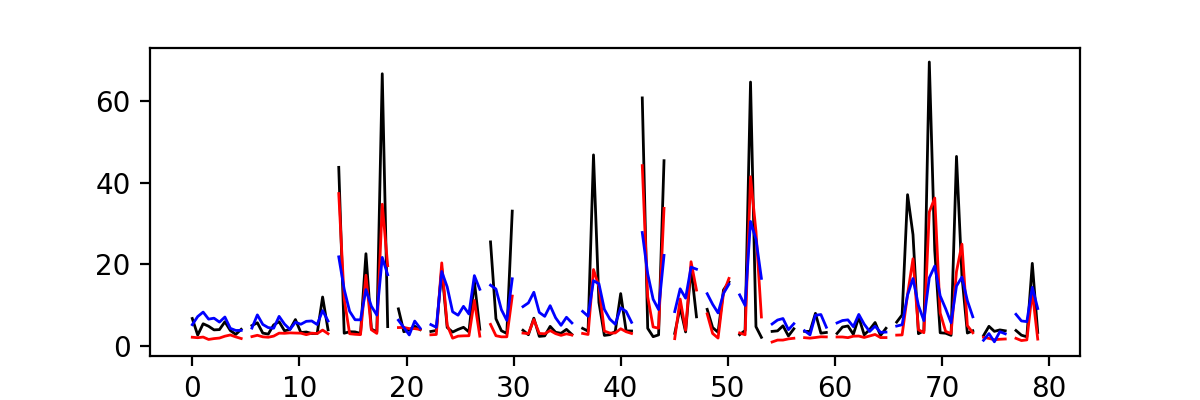

In [44]:
fig, ax = plt.subplots(figsize=[6,figsize[1]])

plot_segmented_signal(tm_pts=ex_comb_preds['t'], sig=ex_comb_preds['truth'][:,0], ax=ax, color='k', 
                      remove_tm_btw_chunks=True)
plot_segmented_signal(tm_pts=ex_comb_preds['t'], sig=ex_comb_preds['est'][:,0], ax=ax, color='r',
                      remove_tm_btw_chunks=True)

plot_segmented_signal(tm_pts=ex_ind_preds['t'], sig=ex_ind_preds['est'][:,0], ax=ax, color='b',
                      remove_tm_btw_chunks=True)

save_name = 'ex_sigs' + '.eps'
save_path = pathlib.Path(save_folder) / save_name
fig.savefig(save_path, format='eps')

In [41]:
figsize

[3, 2]

In [ ]:
6,2